# Potential Student Accommodation Locations in London

## By Benjamin Frost 2019

### The aim of this project is to be able to confidently recommend to a student accommodation company the best location within London to set up their new building. 
#### We will be looking at the proximity of universities to each other, along with the density of existing student accommodations.
#### We will also retrieve the number of students at each university and use this data to try and guage demand for accommodation.
#### Finally, we will be looking at the prices of properties in each borough that we have a university for, and seeing how the prices change as you get close to the center of London.

## Part 1: Accessing and cleaning our data.

Loading in the necessary libraries and enabling matplotlib to display graphs inline using the magic notation

In [224]:
import pandas as pd
#!pip install folium
import folium
import geopy
import requests
import sklearn as sk
from sklearn.cluster import KMeans 
import numpy as np
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

print("Libraries imported")

Libraries imported


Loading in the raw data for use in this project. I wanted a list of all universities within the city of London and not just the universities within central london.
This way I can compare and contrast the locations of existing student halls and housing prices and how they change as they get closer to the center.

Data source: https://en.wikipedia.org/wiki/List_of_universities_and_higher_education_colleges_in_London

In [225]:
# The code was removed by Watson Studio for sharing.

,University,GUG,TUG,CUG,UoL,AMBA,EQUIS,QS,THE,RG,GT,ARWU
0,"Birkbeck, University of London",113.0,122,115,NaN,NaN,NaN,308,301-350,NaN,NaN,NaN
1,Brunel University London,72.0,59,47,NaN,NaN,NaN,346,351-400,NaN,NaN,401-500
2,"City, University of London",32.0,75,42,NaN,NaN,NaN,343,351-400,NaN,NaN,NaN
3,"Goldsmiths, University of London",64.0,63,51,NaN,NaN,NaN,398,301-350,NaN,NaN,NaN
4,Imperial College London,6.0,4,5,a,NaN,NaN,8,8,NaN,NaN,27


The data that's been loaded in here also contains information about university rankings. In order to solve the problem that has been set for us, we only need the column containing the names of the universities.

In [226]:
df_uni = df_raw[['University']]
df_uni.head()

,University
0,"Birkbeck, University of London"
1,Brunel University London
2,"City, University of London"
3,"Goldsmiths, University of London"
4,Imperial College London


## Part 2: Accessing and loading location coordinates for each university.

This function will keep trying to retrieve the geolocator information if the connection times out. This is because Geopy is known to be a sometimes temperamental library.

In [227]:
def do_geocode(address):
    try:
        return geolocator.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

In order to display the universities on a map, we need to retrieve their coordinates from the Geopy library. We will always have a response from geopy since it will loop if the connection times out. We have a 'try:' statement here since the library returns 'none' if it cannot find coordinates for the university.

In [228]:
lat = []
long = []

for uni in df_uni['University']:
    
    geolocator = geopy.geocoders.Nominatim(user_agent="foursquare_agent")
    
    location = do_geocode(uni) 
    
    try: 
        latitude = location.latitude
        longitude = location.longitude
    except:
        lat.append(0)
        long.append(0)
        continue
    
    lat.append(latitude)
    long.append(longitude)

lat

[0,
 51.53255315,
 51.5217668,
 0,
 51.49887085,
 51.4698444,
 51.43725535,
 51.5481558,
 51.51442905,
 51.497788,
 51.59029705,
 51.5247272,
 0,
 0,
 0,
 51.43587325,
 51.5231607,
 51.50727345,
 51.4825423,
 51.4487292,
 51.5176423,
 51.4895194,
 51.51825155]

Converting the longitudes and latitudes to dataframes.

In [229]:
df_lat = pd.DataFrame(lat)
df_long = pd.DataFrame(long)

If the Geopy library has failed to find the university we were searching for, we want to remove that university from the dataset. Since we have many universities in our dataset and only a few failed to be found, this should not impact our results significantly.

In [230]:
df_unicoords = df_uni

df_unicoords['Latitude'] = df_lat
df_unicoords['Longitude'] = df_long

df_unicoords = df_unicoords[df_unicoords.Latitude != 0]

df_unicoords.reset_index(inplace=True)

df_unicoords = df_unicoords[['University', 'Latitude', 'Longitude']]

df_unicoords

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,University,Latitude,Longitude
0,Brunel University London,51.532553,-0.473994
1,"City, University of London",51.521767,-0.130191
2,Imperial College London,51.498871,-0.175608
3,King's College London,51.469844,-0.089279
4,Kingston University,51.437255,-0.251575
5,London Metropolitan University,51.548156,-0.106189
6,London School of Economics,51.514429,-0.116588
7,London South Bank University,51.497788,-0.101859
8,Middlesex University,51.590297,-0.229632
9,Queen Mary University of London,51.524727,-0.039310


I created the function 'addUnis' here so that we can add the universities to all the maps we create without having duplicate code.

In [231]:
unis_map = folium.Map(location = [51.521767, -0.130191], zoom_start = 12)

def addUnis(currentMap):
    for lat, lng, name in zip(df_unicoords.Latitude, df_unicoords.Longitude, df_unicoords.University):
        folium.features.Marker(
            [lat, lng],
        radius = 5,
        color = 'blue',
        popup = name,
        fill = True,
        fill_color='blue',
        fill_opacity = 0.5
        ).add_to(currentMap)

addUnis(unis_map)

unis_map

We can see from this map that the universities within the London are quite spread out in the suburbs, with the highest density in the very center of the city.

## Part 3: Accessing student accommodation companies around each university

Next, we want to retrieve the existing student accommodation companies around each university. To do this we will use the Foursquare API.

In [232]:
search_query = 'student hall'
radius = 500
LIMIT = 1000
VERSION = '20180604'

import requests

accommodationresults = []

for i in range(df_unicoords.shape[0]-1):
    uni = df_unicoords.loc[i+1]
    
    latitude = uni['Latitude']
    longitude = uni['Longitude']
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    
    result = requests.get(url).json()
    accommodationresults.append(result)

Adding all of the student accommodation buildings we have just retrieved to a dataframe.

In [233]:
columns = ['name', 'location.lat', 'location.lng']

df_acc = pd.DataFrame(columns=columns)

for result in accommodationresults:
    accommodation = result['response']['venues']
    df_temp = pd.io.json.json_normalize(accommodation)
    
    try:
        df_temp = df_temp.loc[:, columns]
        df_acc = df_acc.append(df_temp)
    except:
        pass

df_acc.reset_index(inplace=True)
df_acc = df_acc[['name', 'location.lat', 'location.lng']]
df_acc.columns = ['Name', 'Latitude', 'Longitude']
df_acc.head()

,Name,Latitude,Longitude
0,Student Advice Centre,51.521978,-0.129787
1,ULU Upper Hall,51.521539,-0.130286
2,"Student Central, University of London",51.522635,-0.131497
3,College Hall,51.522250,-0.131133
4,Ucl Student Centre,51.524740,-0.132354


Displaying the universities alongside their corresponding student halls. The blue markers represent universities, and green markers represent student accommodation companies.

In [234]:
accommodation_map = folium.Map(location=[51.526037,-0.134565], zoom_start=12)

addUnis(accommodation_map)

def addAccommodation(currentMap):
    for lat, lng, name in zip(df_acc.Latitude, df_acc.Longitude, df_acc.Name):
        folium.CircleMarker(
            [lat, lng],
            radius=5, 
            fill=True,
            opacity=1,
            color='green',
            fill_color='green',
            popup=name,
            fill_opacity=1
        ).add_to(currentMap)

addAccommodation(accommodation_map)
        
accommodation_map

From this map, we can tell that universities within the very center of London have the highest number of student accommodation buildings.

## Part 4: Analysing accommodation data

We will cluster these buildings using K-Means clustering, with the aim of selecting groups of buildings that are very close to one another, perhaps indicating a saturation in the market.

We will run the elbow method to test differen values for k and see which value for k will give us the most descriptive results.

As you can see below, a value of 10 for k gives us the highest score and therefore explains the most variance we are likely to get.

In [235]:
nc = range(1,20)

df_kmeans = df_acc[['Latitude', 'Longitude']]

y = df_kmeans['Longitude'].values.reshape(-1,1)

x = df_kmeans['Latitude']

kmeans = [KMeans(n_clusters=i) for i in nc]

score = [kmeans[i].fit(df_kmeans).score(df_kmeans) for i in range(len(kmeans))]

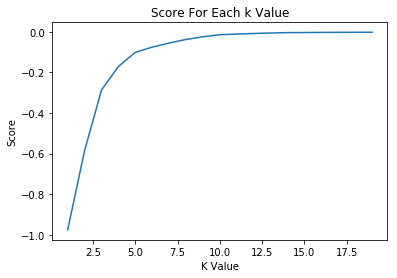

In [236]:
plt.plot(nc,score)
plt.xlabel("K Value")
plt.ylabel("Score")
plt.title("Score For Each k Value")
plt.show()

Clustering our data with a k of 10.

In [237]:
nClusters = 10

k_means = KMeans(init = "k-means++", n_clusters = nClusters, n_init = 12)

k_means.fit(df_kmeans)

labels = k_means.labels_
print(labels)

centers = k_means.cluster_centers_
print(centers)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 9 1 1 1 1 1 1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 7 7 7 0 0 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6
 6 5 5 5 5 5 5 1 1 1 1 1 1 1 1 1 1 9 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1 1 1 1 1 1 8 8 8 2 2 2 2 2 2 2 2 2 2 0 0 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[  5.14427846e+01  -2.46191783e-01]
 [  5.15222171e+01  -1.32743796e-01]
 [  5.14819341e+01  -7.65446256e-03]
 [  5.15893991e+01  -2.29174184e-01]
 [  5.14990892e+01  -1.74780176e-01]
 [  5.14431091e+01  -3.29410956e-01]
 [  5.15232977e+01  -4.17741627e-02]
 [  5.14915718e+01  -9.94096791e-02]
 [  5.15088081e+01   6.32798492e-02]
 [  5.15166202e+01  -1.18210800e-01]]


Plotting the clustered buildings

In [238]:
lat = 5.14970000e+01
long = -1.92887205e-02

df_clustered = df_acc
df_clustered['Cluster Labels'] = labels

clusteredMap = folium.Map([lat, long], zoom_start=10)

x = np.arange(nClusters)
ys = [i + x + (i*x)**2 for i in range(nClusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.rgb2hex(1-i) for i in colors_array]

colors = []
for lat, lon, name, cluster in zip(df_clustered['Latitude'], df_clustered['Longitude'], df_clustered['Name'], df_clustered['Cluster Labels']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=name,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(clusteredMap)

addUnis(clusteredMap)

clusteredMap

This map has reinforced what we have seen from the previous map. The center of london has a very high density of student accommodation buildings, shown by them being grouped together under the same colour.

This simple scatter graph shows us a clearer view of the spread of these buildings.

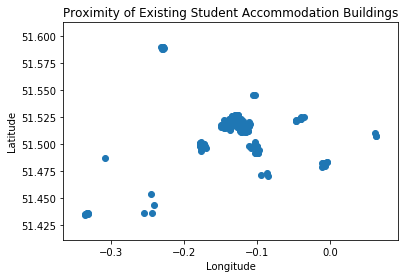

In [239]:
plt.scatter(df_acc['Longitude'], df_acc['Latitude'])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Proximity of Existing Student Accommodation Buildings")
plt.show()

## Part 5: Analysing the relationship between student numbers and distance to the center of the city

Next, we want to calculate the distance of each university to the geographical centre of London.

Coordinates source: https://www.latlong.net/place/london-uk-14153.html

In [240]:
from geopy import distance

centerlat = 51.509865
centerlong = -0.118092

distToCenter = []

for i in range(df_unicoords.shape[0]):
    
    lat = df_unicoords['Latitude'][i]
    long = df_unicoords['Longitude'][i]
    
    dist = geopy.distance.distance([lat,long], [centerlat, centerlong]).km
    
    distToCenter.append(dist)
    
df_distances = df_unicoords

df_distances['Distance'] = distToCenter

df_distances.head()

,University,Latitude,Longitude,Distance
0,Brunel University London,51.532553,-0.473994,24.831126
1,"City, University of London",51.521767,-0.130191,1.568050
2,Imperial College London,51.498871,-0.175608,4.176682
3,King's College London,51.469844,-0.089279,4.881667
4,Kingston University,51.437255,-0.251575,12.299441


We also need to import data about the number of students at each university, which will help us to plot the demand in each area. The function toInt here takes in a dataframe and a column, and will remove any commas in the numbers so that they may be converted to the data type int.

In order to clean up this data, we need to remove any references that may have been added on the wiki page, such as '[a]'

Data source: https://en.wikipedia.org/wiki/List_of_universities_in_the_United_Kingdom_by_enrolment

In [241]:
body = client_d66cdfcf597d4b11b71c7f3c89cf6a1f.get_object(Bucket='pythonamppandas-donotdelete-pr-nhxllkxi7nfnyd',Key='university enrolement.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_enrolement = pd.read_csv(body)

df_enrolement['Institution'] = df_enrolement['Institution'].map(lambda x: x.rstrip('[a][b][c]'))

df_enrolement  = df_enrolement[['Institution', 'Total students']]

df_enrolement.columns=('University', 'Students')

df_enrolement['Students'] = df_enrolement['Students'].map(lambda x: x.rstrip('[4]'))

def toInt(df, column): 
    for i in range(df.shape[0]):
        df[column][i] = "".join(df[column][i].split(","))
    df[column] = df[column].astype(int)

toInt(df_enrolement, 'Students')
    
df_enrolement.set_index('University', inplace=True)

print(df_enrolement.dtypes)
df_enrolement.head()

Students    int64
dtype: object


,Students
University,
University of London,161270
Open University,126210
Open University in England,101490
University of Manchester,40490
University College London,37905


We are now preparing to merge the dataframe containing the number of students in each university with the dataframe containing the universities' coordinates.

In [242]:
try:
    df_unicoords.set_index('University', inplace=True)
except:
    pass

df_unicoords.head()


,Latitude,Longitude,Distance
University,,,
Brunel University London,51.532553,-0.473994,24.831126
"City, University of London",51.521767,-0.130191,1.568050
Imperial College London,51.498871,-0.175608,4.176682
King's College London,51.469844,-0.089279,4.881667
Kingston University,51.437255,-0.251575,12.299441


Thankfully all of the universities that we have been working with have coresponding student numbers in the table we imported.

In [243]:
df_merged = pd.merge(df_unicoords, df_enrolement, left_index=True, right_index=True)

df_merged

,Latitude,Longitude,Distance,Students
University,,,,
Brunel University London,51.532553,-0.473994,24.831126,13130
"City, University of London",51.521767,-0.130191,1.568050,19405
Imperial College London,51.498871,-0.175608,4.176682,17690
King's College London,51.469844,-0.089279,4.881667,30565
Kingston University,51.437255,-0.251575,12.299441,19470
London Metropolitan University,51.548156,-0.106189,4.339511,12145
London School of Economics,51.514429,-0.116588,0.518405,11210
London South Bank University,51.497788,-0.101859,1.753800,17985
Middlesex University,51.590297,-0.229632,11.829639,19505


We are now going to use linear regression to plot a line showing us how the number of students changes based on the university's distance to the center of London.

0.19153612563


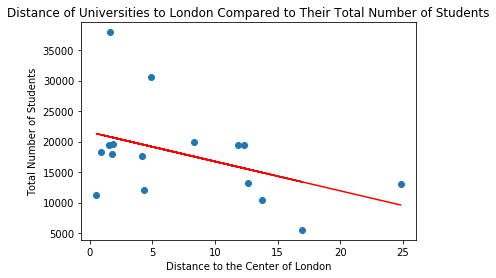

Correlation Strength: 
[[ 1.        -0.4376484]
 [-0.4376484  1.       ]]


In [244]:
train_x = df_merged.Distance.values.reshape(-1,1)
train_y = df_merged.Students

distanceStudents = sk.linear_model.LinearRegression()
distanceStudents.fit(train_x, train_y)

plt.scatter(df_merged.Distance, df_merged.Students)
plt.xlabel("Distance to the Center of London")
plt.ylabel("Total Number of Students")
plt.title("Distance of Universities to London Compared to Their Total Number of Students")
plt.plot(train_x, distanceStudents.coef_*train_x + distanceStudents.intercept_, '-r')
print(distanceStudents.score(train_x, train_y))
plt.show()
print("Correlation Strength: ")
print(np.corrcoef(df_merged.Distance, df_merged.Students))

We can see from this graph that there is a negative correlation between number of students and distance to London.

## Part 6: Analysing the relationship between property prices and distance to the center of the city 

In order to analyse the relationship between distance and property prices, we need to retrieve the boroughs for each university in our dataset. To do this, we will use the API from 'postcodes.io', a resource providing location information within the UK.

I chose to use this API instead of Geopy since postcodes.io gives us a separate result for borough, whereas Geopy only gives us the long format address for each university.

If the API returns a borough for the university, it will be added to the list.

In [245]:
boroughs = []

for lat, long in zip(df_merged['Latitude'], df_merged['Longitude']):
    url = 'http://api.postcodes.io/postcodes?lon={}&lat={}'.format(long,lat)
    result = requests.get(url).json()
    
    try:
        borough = result['result'][0]['primary_care_trust']
        print(borough)
        boroughs.append(borough)
    except:
        print("")
        boroughs.append("")

Hillingdon
Camden
Westminster
Southwark
Wandsworth
Islington
Westminster
Southwark
Barnet
Richmond and Twickenham
Camden
Newham

Camden
Hounslow
Westminster


One of our universities did not have a corresponding borough retrieved by the API, so I've corrected this manually.

In [246]:
df_merged['Borough'] = boroughs

df_merged.at['University of Greenwich', 'Borough']='Greenwich'

df_merged.reset_index(inplace=True)
df_merged

,University,Latitude,Longitude,Distance,Students,Borough
0,Brunel University London,51.532553,-0.473994,24.831126,13130,Hillingdon
1,"City, University of London",51.521767,-0.130191,1.568050,19405,Camden
2,Imperial College London,51.498871,-0.175608,4.176682,17690,Westminster
3,King's College London,51.469844,-0.089279,4.881667,30565,Southwark
4,Kingston University,51.437255,-0.251575,12.299441,19470,Wandsworth
5,London Metropolitan University,51.548156,-0.106189,4.339511,12145,Islington
6,London School of Economics,51.514429,-0.116588,0.518405,11210,Westminster
7,London South Bank University,51.497788,-0.101859,1.753800,17985,Southwark
8,Middlesex University,51.590297,-0.229632,11.829639,19505,Barnet
9,"St Mary's University, Twickenham",51.435873,-0.331961,16.987852,5535,Richmond and Twickenham


Accessing data about housing prices for each borough. This is a very large dataset, but we only need the most recent data, and we only want the median housing prices for each borough. This cuts our dataset down from 12015 rows to 45 rows.

Data source: https://data.london.gov.uk/dataset/average-house-prices?resource=b1b0079e-698c-4c0b-b8c7-aa6189590ca4

In [247]:
body = client_d66cdfcf597d4b11b71c7f3c89cf6a1f.get_object(Bucket='pythonamppandas-donotdelete-pr-nhxllkxi7nfnyd',Key='land-registry-house-prices-borough.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_prices = pd.read_csv(body)
df_prices = df_prices[df_prices.Year == 'Year ending Dec 2017']
df_prices = df_prices[df_prices.Measure == 'Median']
df_prices.reset_index(inplace=True)
df_prices = df_prices[['Area', 'Value']]
df_prices.columns = ['Borough', 'Value']

toInt(df_prices, 'Value')

print(df_prices.shape)
df_prices.head()

(45, 2)


,Borough,Value
0,City of London,835000
1,Barking and Dagenham,300000
2,Barnet,533500
3,Bexley,342500
4,Brent,499950


Below is the final dataset we will be working with. The data has been cleaned, set to the correct data type, merged with other relevant tables.

In [254]:
df_pricesMerged = pd.merge(df_merged, df_prices, on="Borough")
df_pricesMerged.sort_values(by=['Distance'], inplace=True, ascending=False)
df_pricesMerged.reset_index(inplace=True)
df_pricesMerged = df_pricesMerged[['University', 'Latitude', 'Longitude', 'Distance', 'Students', 'Borough', 'Value']]
df_pricesMerged

,University,Latitude,Longitude,Distance,Students,Borough,Value
0,Brunel University London,51.532553,-0.473994,24.831126,13130,Hillingdon,415000
1,University of West London,51.489519,-0.313640,13.766399,10390,Hounslow,395000
2,University of East London,51.507273,0.064405,12.673621,13215,Newham,390500
3,Kingston University,51.437255,-0.251575,12.299441,19470,Wandsworth,654000
4,Middlesex University,51.590297,-0.229632,11.829639,19505,Barnet,533500
5,University of Greenwich,51.482542,-0.006653,8.314634,19915,Greenwich,420000
6,King's College London,51.469844,-0.089279,4.881667,30565,Southwark,530000
7,London Metropolitan University,51.548156,-0.106189,4.339511,12145,Islington,615000
8,Imperial College London,51.498871,-0.175608,4.176682,17690,Westminster,1025000
9,University of Westminster,51.518252,-0.141074,1.848184,19650,Westminster,1025000


Our final machine learning algorithm we will use will be polynomial regression. As you can see below, this fits our data nicely and shows a quadratic growth of housing prices as we get closer to the center of the city.

The data fit well to a polynomial graph of degree 2, and did not fit well at all to a graph of any higher degree.

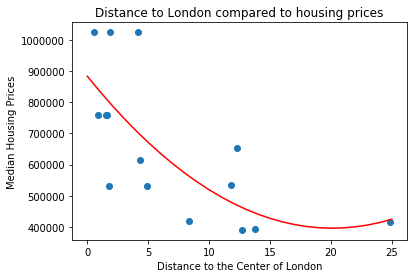

883784.354585


In [249]:
train_x = df_pricesMerged.Distance.values.reshape(-1,1)
train_y = df_pricesMerged.Value

distanceValuePoly = sk.preprocessing.PolynomialFeatures(degree=2)

train_x_poly = distanceValuePoly.fit_transform(train_x)
train_x_poly

distanceValueLinear = sk.linear_model.LinearRegression()
poly = distanceValueLinear.fit(train_x_poly, train_y)

x_vals = np.arange(0,max(train_x+1), 1)

plt.scatter(df_pricesMerged.Distance, df_pricesMerged.Value)
plt.xlabel("Distance to the Center of London")
plt.ylabel("Median Housing Prices")
plt.title("Distance to London compared to housing prices")
plt.plot(x_vals, x_vals * poly.coef_[1] + np.power(x_vals, 2) * poly.coef_[2] + poly.intercept_, '-r')
plt.show()
print(poly.intercept_)

## Part 7: Conclusion

Thank you for readin my notebook this far. If you would like to read the conclusions I have drawn from this data please visit my GitHub repository: https://github.com/BenMarkFrost/Coursera_Capstone

Benjamin Frost 2019